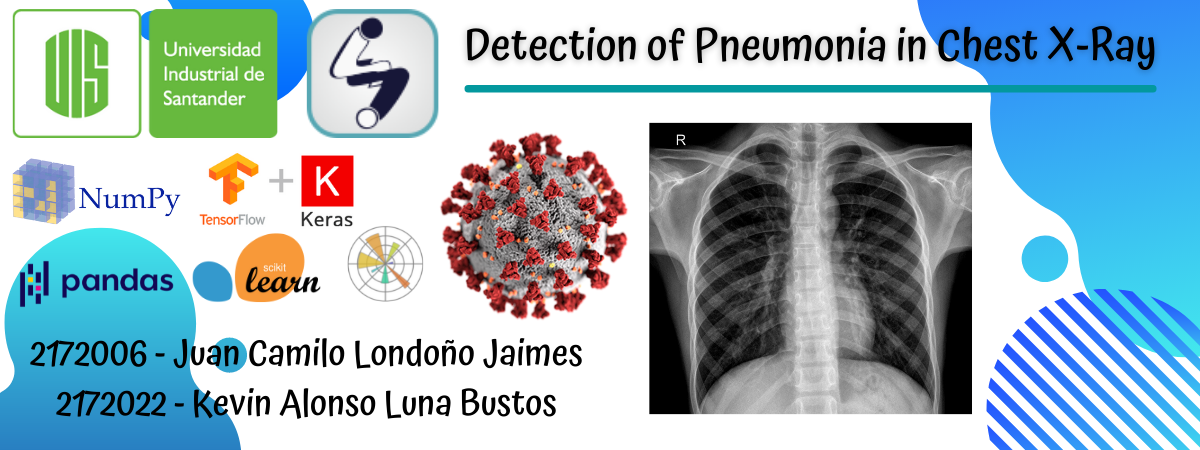

# Detection of Pneumonia in Chest X-Ray Images

***Integrantes:***
* 2172006 - Juan Camilo Londoño Jaimes
* 2172022 - Kevin Alonso Luna Bustos

## **Contexto** 

Hoy en día la humanidad se ve afectada por la aparición de la enfermedad COVID-19, la cual afecta el sistema respiratorio de las personas. Debido a la magnitud de la enfermedad se hace necesario tener una forma confiable para identificarla. El análisis de imágenes de radiografía de tórax es uno de los métodos más importantes para la detección de la enfermedad, ya que la neumonía es uno de los síntomas más graves que puede producir la COVID-19.

## **Datos** 

Para la realización del proyecto se utilizó el dataset [CoronaHack -Chest X-Ray-Dataset](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset) de la plataforma Kaggle. En este se encuentran más de 5800 imágenes de radiografías de tórax en pacientes con neumonía y sin neumonía (Sanos).

#Descarga de Datos


In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanlondoo","key":"72e38e57768966a7a6b8b3b7776f343f"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/')
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

100% 1.18G/1.19G [00:26<00:00, 58.5MB/s]
100% 1.19G/1.19G [00:26<00:00, 48.0MB/s]


In [ ]:
!mkdir -p '/content/drive/MyDrive/Proyecto IA2/'

In [ ]:
!mkdir -p '/content/drive/MyDrive/Proyecto IA2/Coronahack-Chest'

In [ ]:
!unzip coronahack-chest-xraydataset.zip -d '/content/drive/MyDrive/Proyecto IA2/Coronahack-Chest' 

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/drive/MyDrive/Proyecto IA2/Coronahack-Chest/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0446-0001.jpeg  
  inflating: /content/drive/MyDrive/Proyecto IA2/Coronahack-Chest/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0447-0001.jpeg  
  inflating: /content/drive/MyDrive/Proyecto IA2/Coronahack-Chest/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0448-0001.jpeg  
  inflating: /content/drive/MyDrive/Proyecto IA2/Coronahack-Chest/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0449-0001.jpeg  
  inflating: /content/drive/MyDrive/Proyecto IA2/Coronahack-Chest/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0450-0001.jpeg  
  inflating: /content/drive/MyDrive/Proyecto IA2/Coronahack-Chest/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0451-0001.jpeg  
  inflating: /content/drive

#Tratamiento de Datos

In [ ]:
#@title #1. MONTAR EL DRIVE  { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Proyecto IA2')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/Proyecto IA2


In [ ]:
#@title #IMPORT LIBRARIES
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, array_to_img
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [ ]:
#@title Lectura de archivo CSV y creación de datasets
csvpath=r'/content/drive/My Drive/Proyecto IA2/Coronahack-Chest/Chest_xray_Corona_Metadata.csv'
testpath=r'/content/drive/My Drive/Proyecto IA2/Coronahack-Chest/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
trainpath=r'/content/drive/My Drive/Proyecto IA2/Coronahack-Chest/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
df=pd.read_csv(csvpath)
df=df.drop(['Unnamed: 0', 'Label_2_Virus_category', 'Label_1_Virus_category'], axis=1 )
df.columns=['filepaths', 'labels', 'dataset']
groups=df.groupby('dataset')
for d in df['dataset'].unique():
    group=groups.get_group(d)    
    if d == 'TEST':
        test_df=group
        test_df['filepaths']=test_df['filepaths'].apply(lambda x : os.path.join(testpath,x))
    else:
        ndf=group
        ndf['filepaths']=ndf['filepaths'].apply(lambda x : os.path.join(trainpath,x))
print ('ndf length: ', len(ndf), '  test_df length: ', len(test_df))
trsplit=.8
train_df, valid_df = train_test_split(ndf, train_size=trsplit, shuffle=True, random_state=123)

print ('train_df length: ', len(train_df), '  valid__df length: ', len(valid_df))
print (train_df['labels'].value_counts()) 
print( df['filepaths'].iloc[0])

ndf length:  5286   test_df length:  624
train_df length:  4228   valid__df length:  1058
Pnemonia    3155
Normal      1073
Name: labels, dtype: int64
IM-0128-0001.jpeg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
#@title Se balancean las clases
sample_list=[]
max_size= 1073
min_size = 0
groups=train_df.groupby('labels')
for label in train_df['labels'].unique():                 
    group=groups.get_group(label)
    sample_count=len(group)    
    if sample_count> max_size :
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
        sample_list.append(samples)
    elif sample_count>= min_size:
        sample_list.append(group)
train_df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(train_df))     
print (train_df['labels'].value_counts())  

2146
Pnemonia    1073
Normal      1073
Name: labels, dtype: int64


In [ ]:
#@title Se crean los generadores para train, test y validation
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img 
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  78   test steps:  8
Found 2146 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.


In [ ]:
#@title Función para mostrar imágenes con su label
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

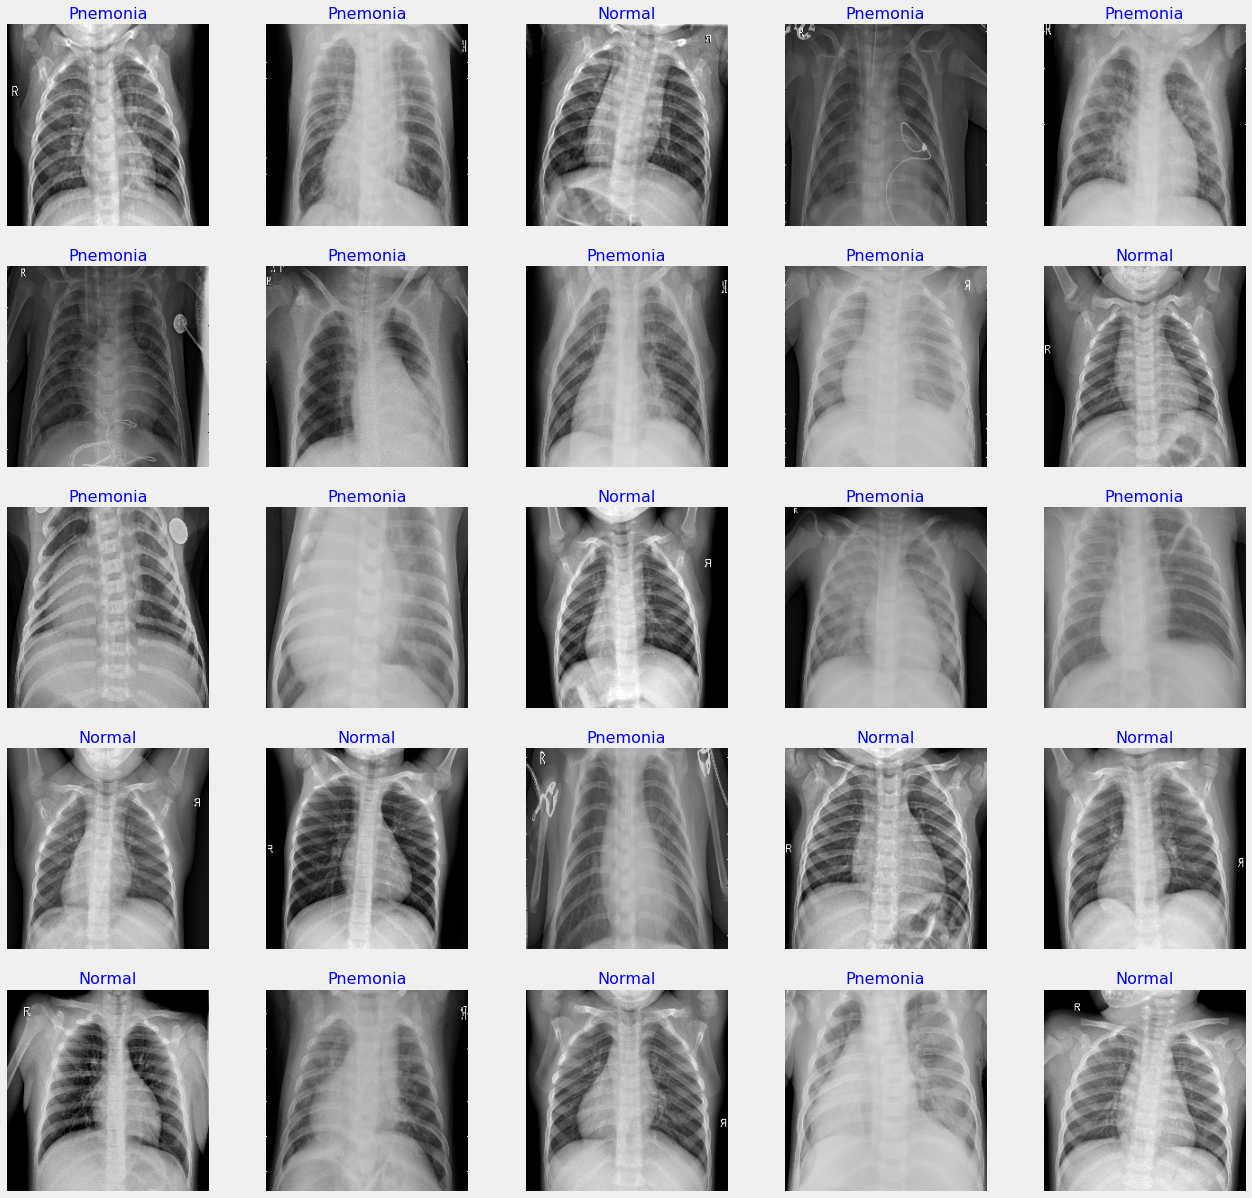

In [ ]:
show_image_samples(train_gen)

#Desarrollo


In [ ]:
#@title Función para graficar los datos
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
#@title Función para generar matriz de confusión y reporte de clasificación
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

#Modelo 1

In [ ]:
#@title Modelo 1: EfficientNetB1
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model1=Model(inputs=base_model.input, outputs=output)
model1.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary() 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

In [ ]:
#@title Entrenamiento Modelo 1
history = model1.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=20,
    validation_data=valid_gen,
    validation_steps=None,
    verbose = True)

Epoch 1/20
30/30 [==============================] - 190s 6s/step - loss: 6.9196 - accuracy: 0.8971 - val_loss: 6.4754 - val_accuracy: 0.8979
Epoch 2/20
30/30 [==============================] - 79s 3s/step - loss: 5.2808 - accuracy: 0.9654 - val_loss: 4.8745 - val_accuracy: 0.9707
Epoch 3/20
30/30 [==============================] - 65s 2s/step - loss: 4.1955 - accuracy: 0.9717 - val_loss: 3.9890 - val_accuracy: 0.9631
Epoch 4/20
30/30 [==============================] - 52s 2s/step - loss: 3.4347 - accuracy: 0.9817 - val_loss: 3.2781 - val_accuracy: 0.9641
Epoch 5/20
30/30 [==============================] - 50s 2s/step - loss: 2.9182 - accuracy: 0.9733 - val_loss: 2.7787 - val_accuracy: 0.9669
Epoch 6/20
30/30 [==============================] - 49s 2s/step - loss: 2.5072 - accuracy: 0.9808 - val_loss: 2.4443 - val_accuracy: 0.9206
Epoch 7/20
30/30 [==============================] - 49s 2s/step - loss: 2.1745 - accuracy: 0.9831 - val_loss: 2.0684 - val_accuracy: 0.9660
Epoch 8/20
30/30 [=

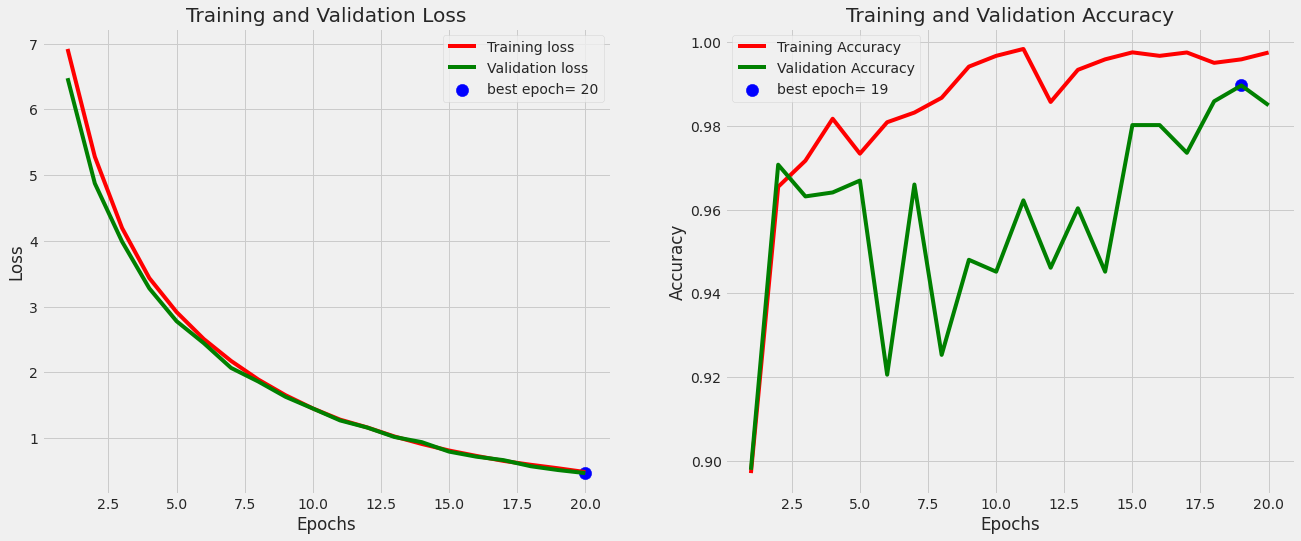

8/8 [==============================] - 9s 913ms/step - loss: 0.9218 - accuracy: 0.8205
accuracy on the test set is 82.05 %


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
#@title Se evalúa el modelo con los datos de test y se guarda
tr_plot(history,0)
save_dir=r'./'
subject='xrays'
acc=model1.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model1.save(save_loc)

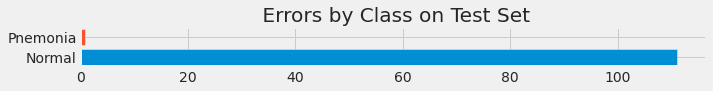

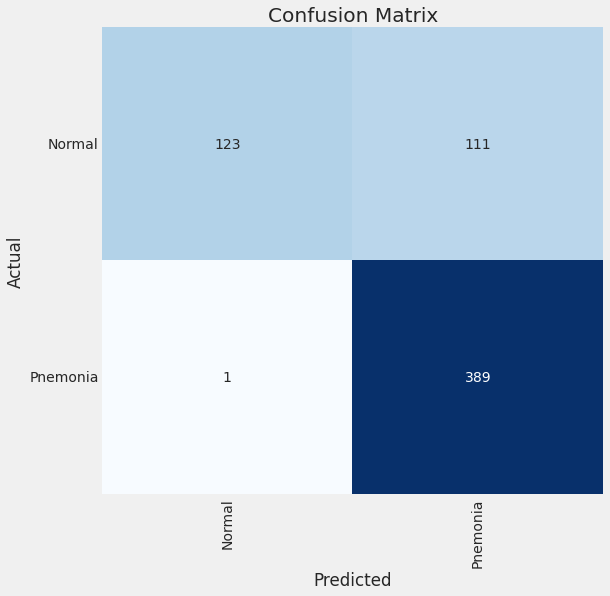

Classification Report:
----------------------
               precision    recall  f1-score   support

      Normal       0.99      0.53      0.69       234
    Pnemonia       0.78      1.00      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.86      0.82      0.80       624



In [ ]:
#@title Se genera la matriz de confusión y el reporte
print_code=0
preds=model1.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

#Modelo 2

In [ ]:
#@title Modelo 2: CNN 51M Params

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same', input_shape=img_shape))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(128, kernel_initializer='glorot_uniform', bias_initializer='he_uniform',  activation='relu'))
model2.add(tf.keras.layers.Dense(class_count, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.001)
model2.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 112, 112, 64)      2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#@title Entrenamiento Modelo 2
history2 = model2.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=20,
    validation_data=valid_gen,
    validation_steps=None,
    verbose = True)

Epoch 1/20
30/30 [==============================] - 56s 2s/step - loss: 15.5084 - accuracy: 0.8117 - val_loss: 806.7880 - val_accuracy: 0.3733
Epoch 2/20
30/30 [==============================] - 44s 1s/step - loss: 0.1862 - accuracy: 0.9358 - val_loss: 37.7645 - val_accuracy: 0.6144
Epoch 3/20
30/30 [==============================] - 48s 2s/step - loss: 0.1110 - accuracy: 0.9578 - val_loss: 1.6884 - val_accuracy: 0.5614
Epoch 4/20
30/30 [==============================] - 44s 1s/step - loss: 0.0848 - accuracy: 0.9680 - val_loss: 1.0914 - val_accuracy: 0.6219
Epoch 5/20
30/30 [==============================] - 44s 1s/step - loss: 0.1207 - accuracy: 0.9688 - val_loss: 0.3599 - val_accuracy: 0.8261
Epoch 6/20
30/30 [==============================] - 44s 1s/step - loss: 0.1379 - accuracy: 0.9452 - val_loss: 0.9766 - val_accuracy: 0.6597
Epoch 7/20
30/30 [==============================] - 43s 1s/step - loss: 0.0992 - accuracy: 0.9629 - val_loss: 0.2417 - val_accuracy: 0.8516
Epoch 8/20
30/30

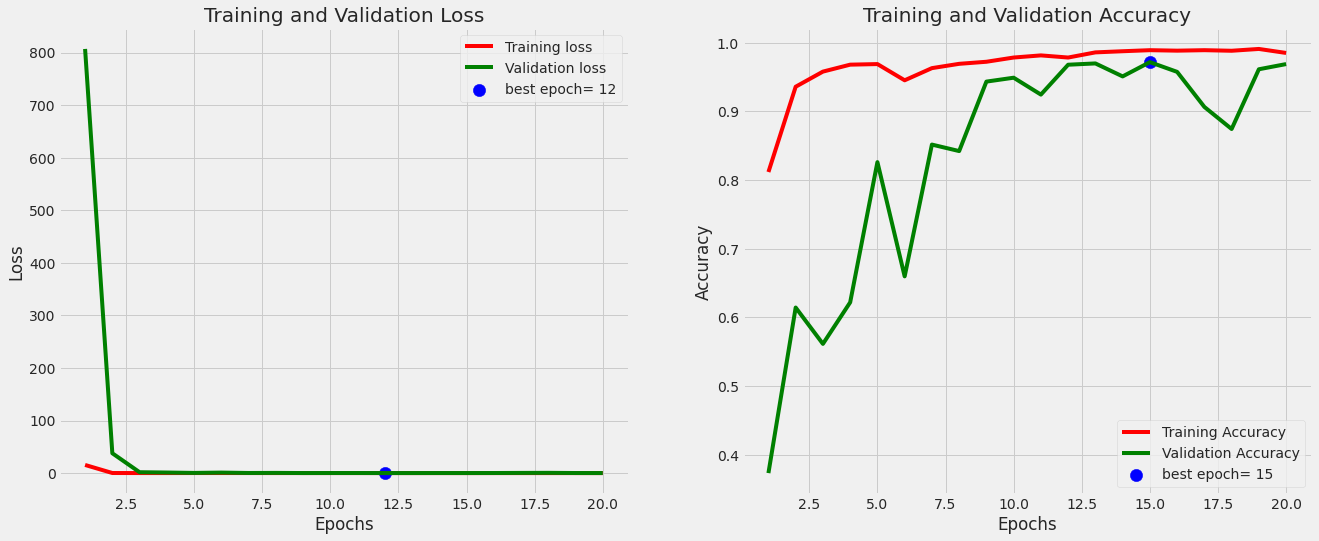

8/8 [==============================] - 14s 760ms/step - loss: 1.1729 - accuracy: 0.7853
accuracy on the test set is 78.53 %


In [ ]:
#@title Se evalúa el modelo con los datos de test y se guarda
tr_plot(history2,0)
save_dir=r'./'
subject='xrays2'
acc=model2.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model2.save(save_loc)

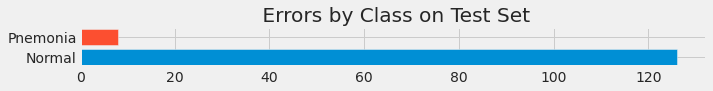

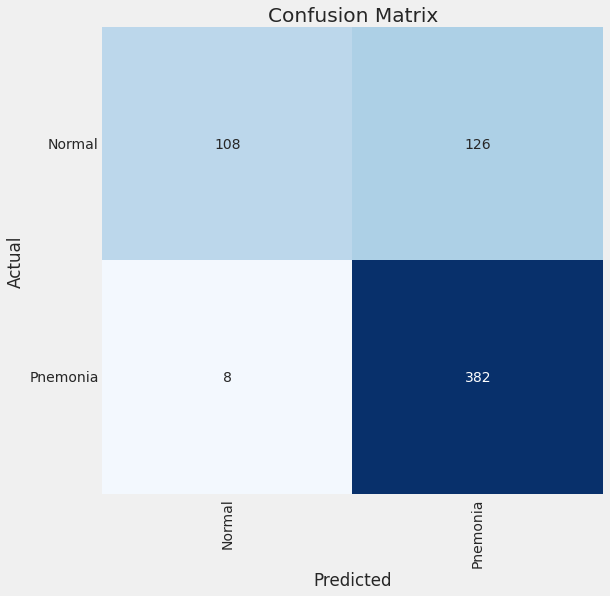

Classification Report:
----------------------
               precision    recall  f1-score   support

      Normal       0.93      0.46      0.62       234
    Pnemonia       0.75      0.98      0.85       390

    accuracy                           0.79       624
   macro avg       0.84      0.72      0.73       624
weighted avg       0.82      0.79      0.76       624



In [ ]:
#@title Se genera la matriz de confusión y el reporte
print_code=0
preds=model2.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

#Modelo 3

In [ ]:
#@title Modelo 3: CNN 1M Params

model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers. Conv2D(filters=10, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=img_shape))
model3.add(tf.keras.layers. Conv2D(10, 3, activation='relu'))
model3.add(tf.keras.layers. Conv2D(10, 3, activation='relu'))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(class_count, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.001)
model3.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 10)      280       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 222, 222, 10)      910       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 484000)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 968002    
Total params: 970,102
Trainable params: 970,102
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#@title Entrenamiento Modelo 3
history3 = model3.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=20,
    validation_data=valid_gen,
    validation_steps=None,
    verbose = True)

Epoch 1/20
30/30 [==============================] - 41s 1s/step - loss: 1263.6113 - accuracy: 0.6071 - val_loss: 18.1091 - val_accuracy: 0.8771
Epoch 2/20
30/30 [==============================] - 39s 1s/step - loss: 14.4497 - accuracy: 0.9030 - val_loss: 4.6958 - val_accuracy: 0.9414
Epoch 3/20
30/30 [==============================] - 38s 1s/step - loss: 5.0245 - accuracy: 0.9376 - val_loss: 2.5626 - val_accuracy: 0.9565
Epoch 4/20
30/30 [==============================] - 39s 1s/step - loss: 2.4857 - accuracy: 0.9500 - val_loss: 1.7797 - val_accuracy: 0.9565
Epoch 5/20
30/30 [==============================] - 38s 1s/step - loss: 2.0960 - accuracy: 0.9458 - val_loss: 2.5100 - val_accuracy: 0.9480
Epoch 6/20
30/30 [==============================] - 38s 1s/step - loss: 1.4956 - accuracy: 0.9567 - val_loss: 1.6235 - val_accuracy: 0.9660
Epoch 7/20
30/30 [==============================] - 38s 1s/step - loss: 2.1987 - accuracy: 0.9358 - val_loss: 2.0842 - val_accuracy: 0.9527
Epoch 8/20
30/3

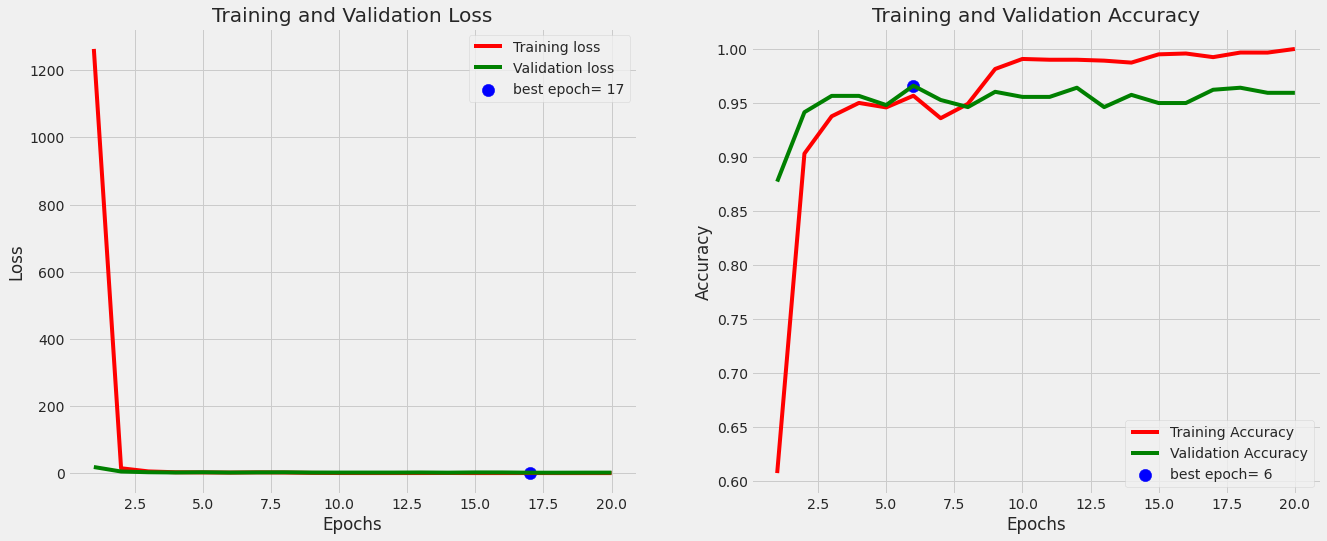

8/8 [==============================] - 8s 772ms/step - loss: 11.3370 - accuracy: 0.7788
accuracy on the test set is 77.88 %


In [ ]:
#@title Se evalúa el modelo con los datos de test y se guarda
tr_plot(history3,0)
save_dir=r'./'
subject='xrays3'
acc=model3.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model3.save(save_loc)

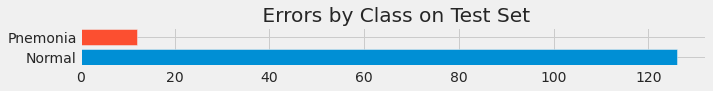

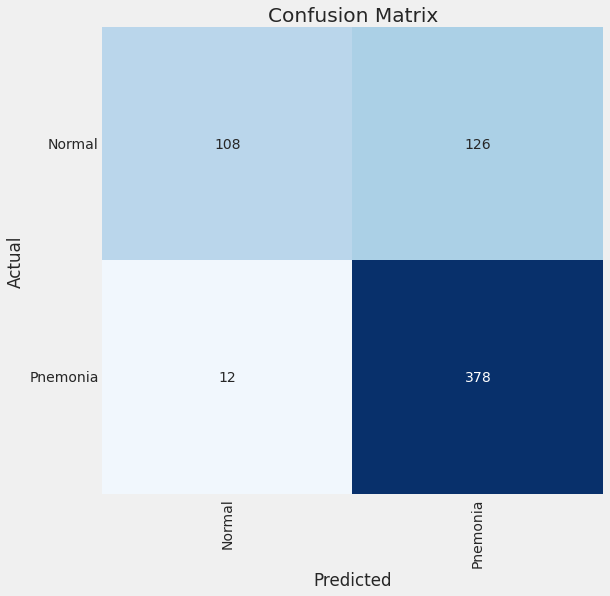

Classification Report:
----------------------
               precision    recall  f1-score   support

      Normal       0.90      0.46      0.61       234
    Pnemonia       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.82      0.72      0.73       624
weighted avg       0.81      0.78      0.76       624



In [ ]:
#@title Se genera la matriz de confusión y el reporte
print_code=0
preds=model3.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

#Modelo 4

In [ ]:
#@title Modelo 4: VGG16
model_name='VGG16'
base_model=tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model4=Model(inputs=base_model.input, outputs=output)
model4.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary() 

58900480/58889256 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#@title Entrenamiento Modelo 4
history4 = model4.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=20,
    validation_data=valid_gen,
    validation_steps=None,
    verbose = True)

Epoch 1/20
30/30 [==============================] - 69s 2s/step - loss: 5.2920 - accuracy: 0.8492 - val_loss: 29.9777 - val_accuracy: 0.2543
Epoch 2/20
30/30 [==============================] - 50s 2s/step - loss: 3.2217 - accuracy: 0.9258 - val_loss: 21.9500 - val_accuracy: 0.2543
Epoch 3/20
30/30 [==============================] - 57s 2s/step - loss: 2.0338 - accuracy: 0.9351 - val_loss: 1.8426 - val_accuracy: 0.9442
Epoch 4/20
30/30 [==============================] - 50s 2s/step - loss: 1.3584 - accuracy: 0.9368 - val_loss: 14.9358 - val_accuracy: 0.2571
Epoch 5/20
30/30 [==============================] - 49s 2s/step - loss: 0.9955 - accuracy: 0.9233 - val_loss: 3.5907 - val_accuracy: 0.3875
Epoch 6/20
30/30 [==============================] - 50s 2s/step - loss: 0.7108 - accuracy: 0.9376 - val_loss: 4.6816 - val_accuracy: 0.9423
Epoch 7/20
30/30 [==============================] - 50s 2s/step - loss: 0.5623 - accuracy: 0.9392 - val_loss: 27.6152 - val_accuracy: 0.9357
Epoch 8/20
30/30

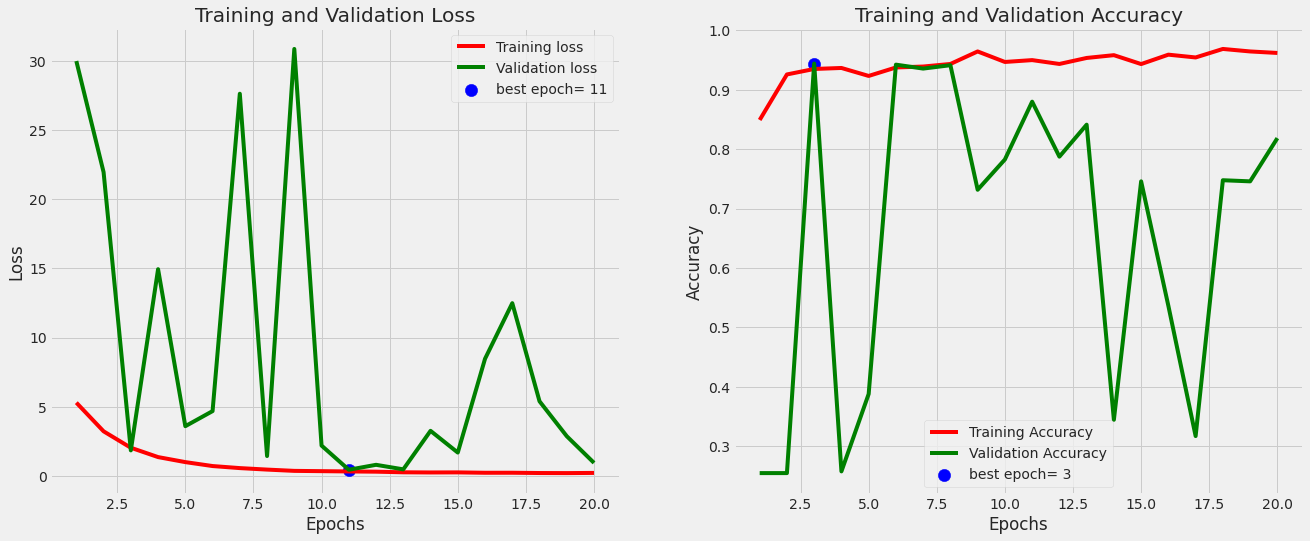

8/8 [==============================] - 22s 839ms/step - loss: 1.5926 - accuracy: 0.7917
accuracy on the test set is 79.17 %


In [ ]:
#@title Se evalúa el modelo con los datos de test y se guarda
tr_plot(history4,0)
save_dir=r'./'
subject='xrays4'
acc=model4.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model4.save(save_loc)

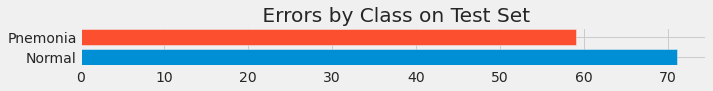

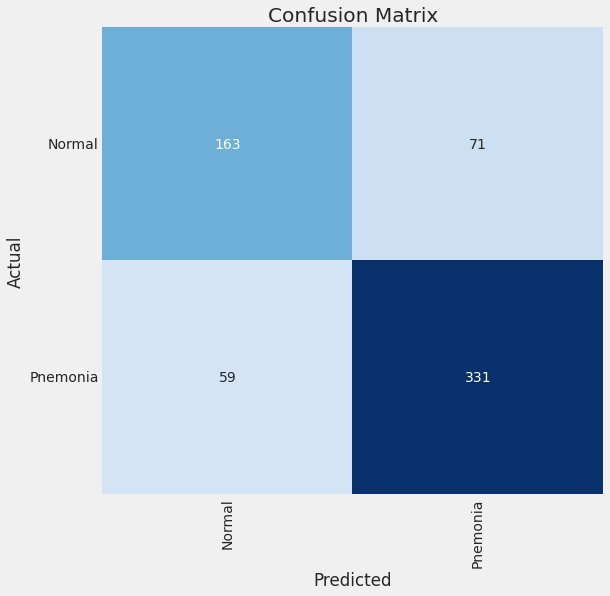

Classification Report:
----------------------
               precision    recall  f1-score   support

      Normal       0.73      0.70      0.71       234
    Pnemonia       0.82      0.85      0.84       390

    accuracy                           0.79       624
   macro avg       0.78      0.77      0.78       624
weighted avg       0.79      0.79      0.79       624



In [ ]:
#@title Se genera la matriz de confusión y el reporte
print_code=0
preds=model4.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

#Modelo 5

In [ ]:
#@title Modelo 5: ResNet50
model_name='ResNet50'
base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model5=Model(inputs=base_model.input, outputs=output)
model5.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary() 

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#@title Entrenamiento Modelo 5
history5 = model5.fit(
    train_gen,
    steps_per_epoch=30,
    epochs=20,
    validation_data=valid_gen,
    validation_steps=None,
    verbose = True)

Epoch 1/20
30/30 [==============================] - 61s 2s/step - loss: 6.7388 - accuracy: 0.9058 - val_loss: 40055.3242 - val_accuracy: 0.7457
Epoch 2/20
30/30 [==============================] - 50s 2s/step - loss: 4.4083 - accuracy: 0.9325 - val_loss: 21520764.0000 - val_accuracy: 0.2543
Epoch 3/20
30/30 [==============================] - 48s 2s/step - loss: 3.4715 - accuracy: 0.9165 - val_loss: 9460983.0000 - val_accuracy: 0.7457
Epoch 4/20
30/30 [==============================] - 48s 2s/step - loss: 2.6479 - accuracy: 0.9250 - val_loss: 2803790.2500 - val_accuracy: 0.7457
Epoch 5/20
30/30 [==============================] - 48s 2s/step - loss: 1.9538 - accuracy: 0.9241 - val_loss: 25246.9902 - val_accuracy: 0.7457
Epoch 6/20
30/30 [==============================] - 48s 2s/step - loss: 1.6789 - accuracy: 0.8980 - val_loss: 9957661.0000 - val_accuracy: 0.7457
Epoch 7/20
30/30 [==============================] - 49s 2s/step - loss: 1.3772 - accuracy: 0.8879 - val_loss: 32764.7969 - val_

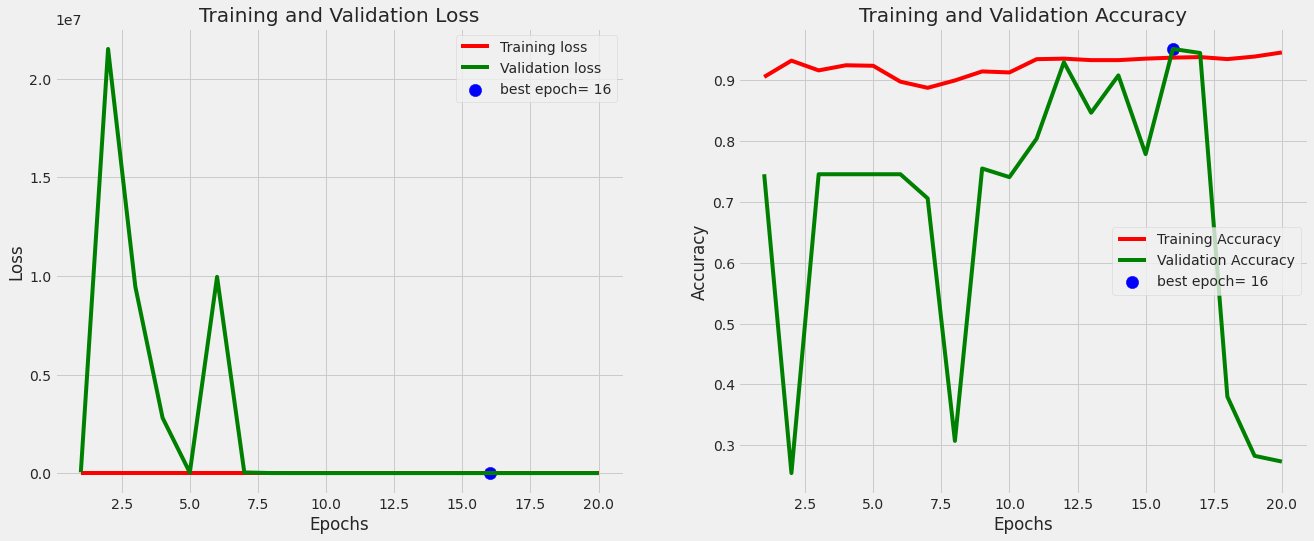

8/8 [==============================] - 9s 939ms/step - loss: 2.6564 - accuracy: 0.6218
accuracy on the test set is 62.18 %


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
#@title Se evalúa el modelo con los datos de test y se guarda
tr_plot(history5,0)
save_dir=r'./'
subject='xrays5'
acc=model4.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model5.save(save_loc)

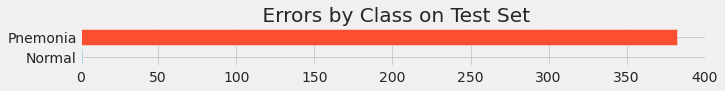

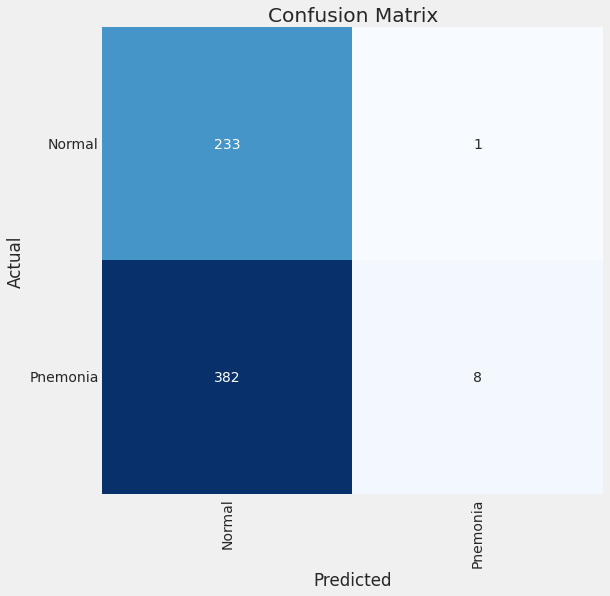

Classification Report:
----------------------
               precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
    Pnemonia       0.89      0.02      0.04       390

    accuracy                           0.39       624
   macro avg       0.63      0.51      0.29       624
weighted avg       0.70      0.39      0.23       624



In [ ]:
#@title Se genera la matriz de confusión y el reporte
print_code=0
preds=model5.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

#Resultados

In [ ]:
#@title Resultados de accuracy
df1 = pd.DataFrame({'Modelo': ["EfficientNetB1", "CNN 51M Params", "CNN 1M Params", "VGG16", "ResNet50"]})
df2 = pd.DataFrame({'Accuracy': [82.05, 78.53, 77.88, 79.17, 62.18]})
df = pd.concat([df1, df2], axis=1)
df

,Modelo,Accuracy
0,EfficientNetB1,82.05
1,CNN 51M Params,78.53
2,CNN 1M Params,77.88
3,VGG16,79.17
4,ResNet50,62.18
